In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import keyroom
import jax
import jax.numpy as jnp
# from gymnax.visualize import Visualizer
import visualizer
from xminigrid.rendering.rgb_render import render
import numpy as np
from IPython.display import Image

/Users/wilka/miniforge3/envs/jaxneurorl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
import json

# Open the file and load the JSON data
with open("maze_pairs.json", "r") as file:
    maze_config = json.load(file)[0]

In [108]:
from pprint import pprint


pprint(maze_config)

env = keyroom.KeyRoom(
    maze_config=keyroom.shorten_maze_config(maze_config, 3))
env_params = env.default_params()
env_params

{'keys': [['key', 'grey'],
          ['key', 'red'],
          ['key', 'purple'],
          ['key', 'yellow']],
 'pairs': [[['box', 'blue'], ['ball', 'blue']],
           [['box', 'purple'], ['box', 'green']],
           [['ball', 'green'], ['box', 'yellow']],
           [['key', 'blue'], ['key', 'green']]]}


KeyRoomEnvParams(height=19, width=19, view_size=7, render_mode='rgb_array', random_door_loc=False, training=True)

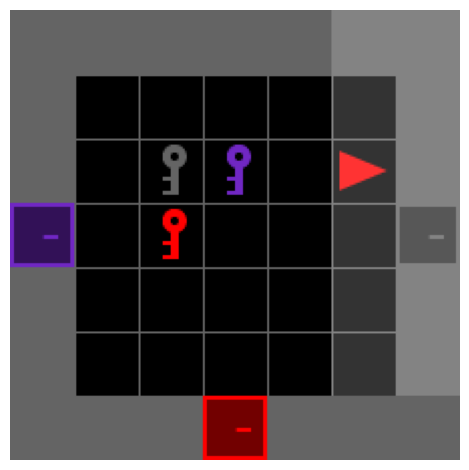

TimeStep(state=EnvState(key=(2,), step_num=(), grid=(19, 19, 4), agent=AgentState(position=(2,), direction=(), pocket=(4,)), carry=EnvCarry(), feature_weights=(3, 4), task_state=TaskState(feature_counts=(3, 4), features=(3, 4))), step_type=(), reward=(), discount=(), observation=Observation(image=(7, 7, 4), task_w=(3, 4), state_features=(3, 4), has_occurred=(3, 4)))

In [102]:
rng = jax.random.PRNGKey(2)
rng, rng_ = jax.random.split(rng)
timestep = env.reset(env_params, rng_)

# get image of full state
# state_image = env.render(env_params, timestep)
# visualizer.display_image(state_image)

# get image of what agent observes (theirs is symbolic)
obs_image = keyroom.render_room(timestep)
visualizer.display_image(obs_image)

jax.tree_map(lambda x:x.shape, timestep)

In [128]:
rng = jax.random.PRNGKey(2)
rng, rng_ = jax.random.split(rng)
timestep = env.reset(env_params, rng_)
t_limit = 100

state_seq = [env.render(env_params, timestep)]
obs_seq = [keyroom.render_room(timestep)]
reward_seq = [timestep.reward]

t_counter = 0
while True:
    rng, rng_act = jax.random.split(rng, 2)
    action = jax.random.randint(rng_act, (), 0, env.num_actions(env_params))

    timestep = env.step(env_params, timestep, action=action)
    state_seq.append(env.render(env_params, timestep))
    obs_seq.append(keyroom.render_room(timestep))
    reward_seq.append(timestep.reward)

    t_counter += 1
    if timestep.last() or t_counter >= t_limit:
        break

cum_rewards = jnp.cumsum(jnp.array(reward_seq))
print(t_counter)

/Users/wilka/miniforge3/envs/jaxneurorl/lib/python3.10/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint8 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


100


In [129]:
print(t_counter, len(reward_seq), len(obs_seq))

100 101 101


MovieWriter ffmpeg unavailable; using Pillow instead.


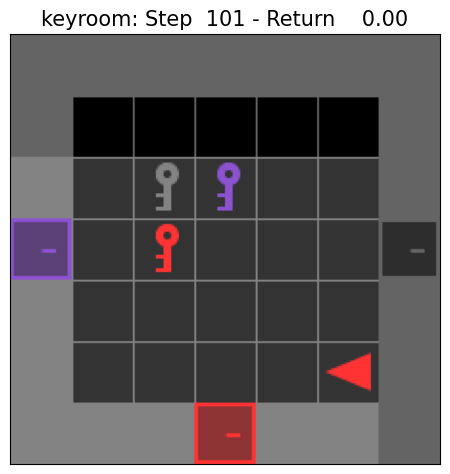

In [130]:
vis = visualizer.Visualizer(env, env_params, obs_seq, cum_rewards)
vis.animate(f"media/anim.gif")
Image(url=f"media/anim.gif")  